# Read in the data

In [2]:
import pandas
import numpy
import matplotlib.pyplot as plt
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pandas.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [3]:
all_survey = pandas.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pandas.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pandas.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_10", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [4]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [5]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pandas.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pandas.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pandas.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [6]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [7]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pandas.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [8]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [9]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [10]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

# Plotting survey correlations

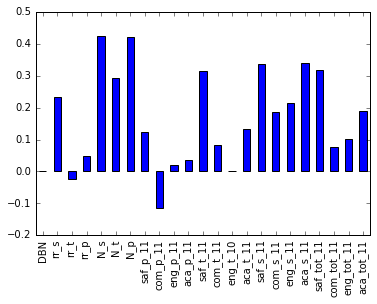

In [11]:
%matplotlib inline
combined.corr()["sat_score"][survey_fields].plot.bar()

There are high correlations between N_s, N_t, N_p and sat_score. Since these columns are correlated with total_enrollment, it makes sense that they would be high.

It is more interesting that rr_s, the student response rate, or the percentage of students that completed the survey, correlates with sat_score. This might make sense because students who are more likely to fill out surveys may be more likely to also be doing well academically.
How students and teachers percieved safety (saf_t_11 and saf_s_11) correlate with sat_score. This make sense, as it's hard to teach or learn in an unsafe environment.

The last interesting correlation is the aca_s_11, which indicates how the student perceives academic standards, correlates with sat_score, but this is not true for aca_t_11, how teachers perceive academic standards, or aca_p_11, how parents perceive academic standards

# Exploring safety

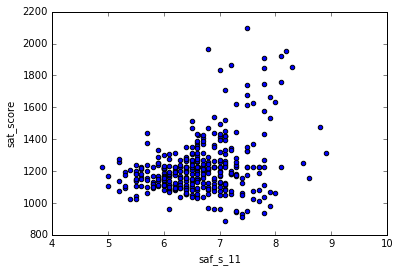

In [12]:
combined.plot.scatter("saf_s_11", "sat_score")

There appears to be a correlation between SAT scores and safety, although it isn't thatstrong. It looks like there are a few schools with extremely high SAT scores and high safety scores. There are a few schools with low safety scores and low SAT scores. No school with a safety score lower than 6.5 has an average SAT score higher than 1500 or so.

# Plotting safety

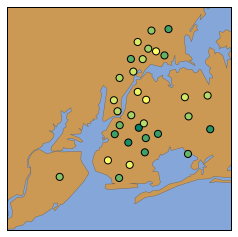

In [13]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

districts = combined.groupby("school_dist").agg(numpy.mean)
districts.reset_index(inplace=True)

m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='h'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)
m.fillcontinents(color='#cc9955',lake_color='aqua')


longitudes = districts["lon"].tolist()
latitudes = districts["lat"].tolist()
m.scatter(longitudes, latitudes, s=50, zorder=2, latlon=True, c=districts["saf_s_11"], cmap="summer")
plt.show()

It looks like Upper Manhattan and parts of Queens and the Bronx tend to have lower safety scores, whereas Brooklyn has high safety scores.

# Race Comparison

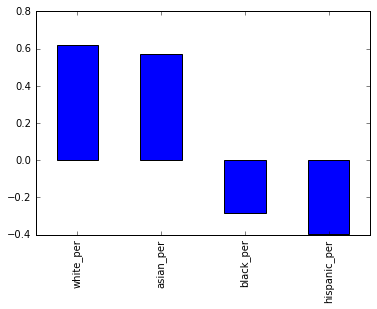

In [14]:
race_fields = ["white_per", "asian_per", "black_per", "hispanic_per"]
combined.corr()["sat_score"][race_fields].plot.bar()

The white and asian communities do significantly better on SAT scores than the black and hispanic ones.

# White Community Map

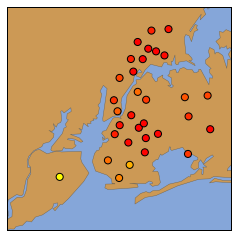

In [15]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='h'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)
m.fillcontinents(color='#cc9955',lake_color='aqua')


m.scatter(longitudes, latitudes, s=50, zorder=2, latlon=True, c=districts["white_per"], cmap="autumn")
plt.show()

Southern Bronx and Staten island are two areas where there are less whites.

# Asian Community Map

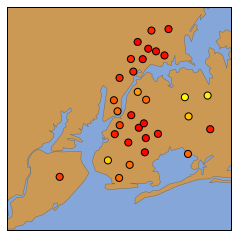

In [16]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='h'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)
m.fillcontinents(color='#cc9955',lake_color='aqua')


m.scatter(longitudes, latitudes, s=50, zorder=2, latlon=True, c=districts["asian_per"], cmap="autumn")
plt.show()

Southern Bronx and Queens island are two areas where there are less asian communites.

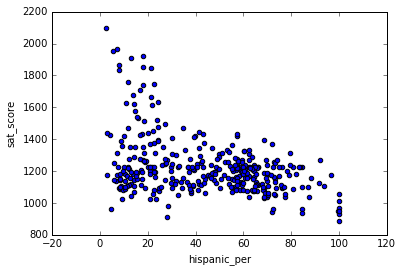

In [17]:
combined.plot.scatter("hispanic_per","sat_score")

In [18]:
hispanic_per_95 = combined[combined["hispanic_per"]>95]

The schools listed above appear to primarily be geared towards recent immigrants to the US. These schools have a lot of students who are learning English, which would explain the lower SAT scores.

In [19]:
low_minority = combined[combined["black_per"]<5]
low_minority = combined[combined["hispanic_per"]<5]

Schools with a low minority percentages seem to be technology oriented and have a very low acceptance rate (e.g. 2.7% - half that of harvard!)

In [20]:
print(combined[(combined["hispanic_per"] < 10) & (combined["sat_score"] > 1800)]["SCHOOL NAME"])

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


Many of the schools above appear to be specialized science and technology schools that receive extra funding, and only admit students who pass an entrance exam. This doesn't explain the low hispanic_per, but it does explain why their students tend to do better on the SAT -- they are students from all over New York City who did well on a standardized test.

# Gender Comparison

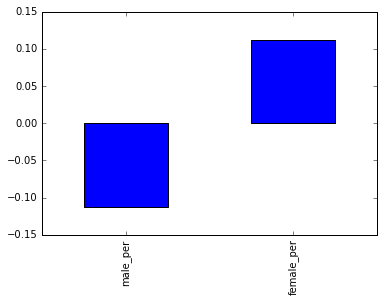

In [21]:
gender = ["male_per", "female_per"]
combined.corr()["sat_score"][gender].plot.bar()

# School Scores

Each school can be assigned a score, that is coprised of the SAT result, school diversity, class size, safety and graduation rate. A high scoring school will have high SAT scores, a diverse school poulation, a low class size, high safety and a high graduation rate. 

In [163]:
combined["scale_sat_score"] = combined["sat_score"]/max(combined["sat_score"])
combined["scale_safety_score"] = combined["saf_s_11"]/max(combined["saf_s_11"])
combined["scale_class_size"] = combined["AVERAGE CLASS SIZE"]/max(combined["AVERAGE CLASS SIZE"])
combined["diversity_score"] = combined["hispanic_per"]*combined["white_per"]*combined["black_per"]*combined["asian_per"]
combined["norm_diversity_score"] = combined["diversity_score"]/max(combined["diversity_score"])

combined["school_score"] = combined["scale_sat_score"] + combined["scale_safety_score"] -combined["scale_class_size"] +combined["norm_diversity_score"]

school_scores = combined[["Name","school_score"]].sort_values(by="school_score",ascending=False)
top_ten_schools = school_scores.head(10)
top_ten_schools = top_ten_schools.set_index("Name")

                                                 Name  school_score
287  BARD HIGH SCHOOL EARLY COLLEGE II                     2.068695
79   HIGH SCHOOL FOR MATHEMATICS SCI AND ENGINEERING       2.020638
5    BARD HIGH SCHOOL EARLY COLLEGE                        1.835262
264  URBAN ASSEMBLY SCHOOL FOR CRIMINAL JUSTICE            1.773165
198  BROOKLYN LATIN                                        1.764921
155  HIGH SCHOOL OF AMERICAN STUDIES AT LEHMAN COLLEG      1.711004
314  THE SCHOLARS ACADEMY                                  1.707113
265  INTERNATIONAL HIGH SCHOOL AT LAFAYETTE                1.670403
36   MANHATTAN INTERNATIONAL HIGH SCHOOL                   1.662473
270  EDWARD R. MURROW HIGH SCHOOL                          1.650432
296  THE QUEENS SCHOOL OF INQUIRY                          1.633968
64   MANHATTAN/HUNTER SCIENCE HIGH SCHOOL                  1.581707
225  INTERNATIONAL HIGH SCHOOL AT PROSPECT HEIGHTS         1.552409
273  EXPEDITIONARY LEARNING SCHOOL FOR COMMUNITY

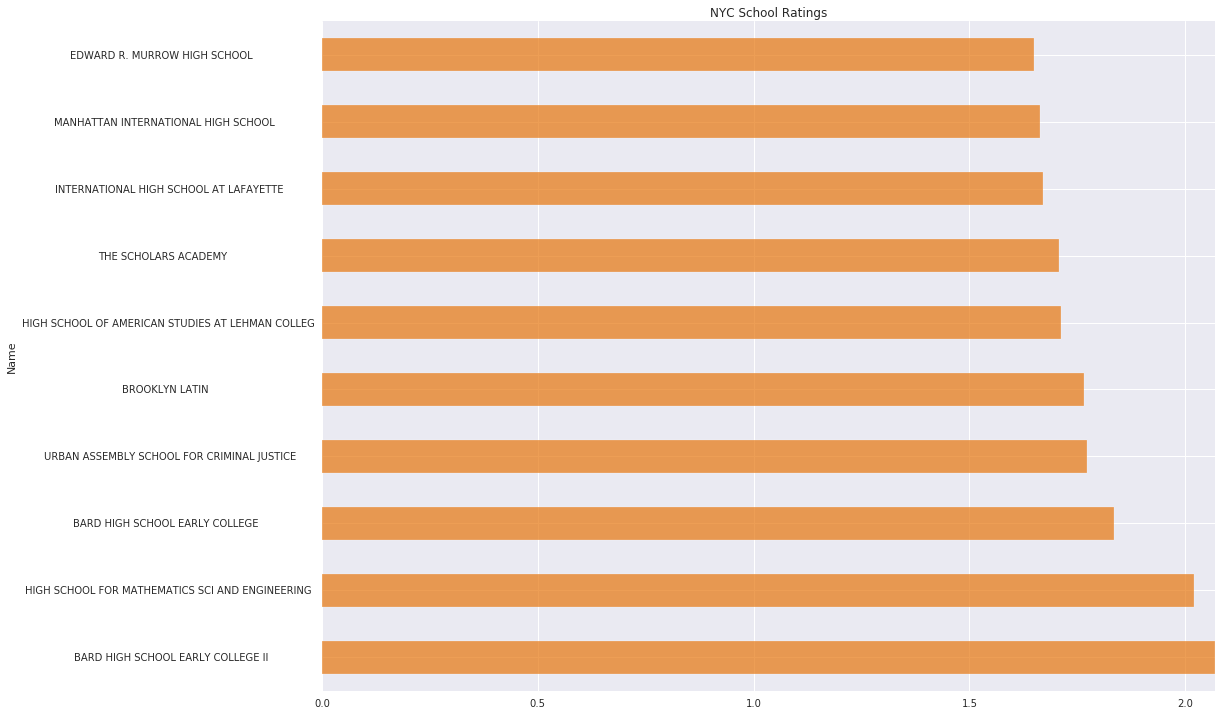

In [164]:
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.lines import Line2D 

# Create a figure of given size
fig = plt.figure(figsize=(16,12))
# Add a subplot
ax = fig.add_subplot(111)
# Set title
ttl = 'NYC School Ratings'
# Set color transparency (0: transparent; 1: solid)
a = 0.7
# Create a colormap
customcmap = [(0.9,  0.46, 0.05) for x in range(len(school_scores))]
# Plot the 'score' column as horizontal bar plot
top_ten_schools["school_score"].plot(kind='barh', ax=ax, alpha=a, legend=False, color=customcmap,
                      edgecolor='w', xlim=(0,max(top_ten_schools["school_score"])), title=ttl)
plt.show()